<a href="https://colab.research.google.com/github/sexymetra/Ai-project/blob/LeeSangHyuck/gru%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EB%B2%84%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 설명
결측값의 비율이 일정수치(hyperparam 에서 missing_value_lowerbound) 이상 넘으면 쓰지 않음

## Hyperparameter Setting

In [55]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#하이퍼 파라미터
hyperparam = {
    'interval': 5, # train data의 day 수
    'missing_value_lowerbound' : 0.01,
    "normalize" : ["None", "Min-max", "Standarzation"][1]
}
constant = {
    'day_to_predict': 2, # 예측해야 하는 day의 수
    'total_day' : 200
}

## Colab drive mount

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 불러오기

In [57]:
Path = "/content/drive/MyDrive/Colab Notebooks/2022 Inha challenge/data/"
raw_data = pd.read_csv(Path+"train_data.csv")


## 데이터 확인

In [58]:
print("raw_data type")
print(type(raw_data))
print()
print("raw_data shape")
print(raw_data.shape)

raw_data type
<class 'pandas.core.frame.DataFrame'>

raw_data shape
(3859200, 13)


## 변수 의미
1. TurbID - 발전기 ID
2. Day - 날짜
3. Tmstamp - 시간(time stamp)
4. Wspd - 풍속
5. Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이
6. Etmp - 외부 온도
7. Itmp - 터빈 내부 온도
8. Ndir - 터빈이 바라보는 방향 각도
9. Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름
10. Prtv - 무효전력 : 에너지원을 필요로  하지 않는 전력
11. Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

In [59]:
raw_data.head(10)

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36
5,1,1,00:50,6.10,-1.03,30.47,41.22,20.91,1.0,1.0,1.0,-0.27,482.21
6,1,1,01:00,6.77,1.07,30.31,41.19,20.91,1.0,1.0,1.0,-0.23,584.75
7,1,1,01:10,6.70,-2.80,30.24,41.00,20.91,1.0,1.0,1.0,-0.23,557.98
8,1,1,01:20,6.44,-3.46,30.13,40.91,20.91,1.0,1.0,1.0,-0.21,503.94
9,1,1,01:30,6.25,-3.15,29.97,40.72,20.91,1.0,1.0,1.0,-0.26,463.37


In [60]:
raw_data.tail(10)

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
3859190,134,200,22:20,4.78,-1.14,9.53,11.13,163.80,0.01,0.01,0.01,-93.81,280.02
3859191,134,200,22:30,4.73,2.49,9.33,10.84,171.85,0.01,0.01,0.01,-100.28,287.80
3859192,134,200,22:40,4.52,-1.10,9.03,10.63,167.25,0.01,0.01,0.01,-85.80,237.50
3859193,134,200,22:50,4.28,2.55,8.93,10.41,164.55,0.01,0.01,0.01,-82.08,228.25
3859194,134,200,23:00,5.13,-0.35,8.86,10.33,171.95,0.01,0.01,0.01,-111.64,318.40
3859195,134,200,23:10,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,23:20,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,23:30,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23:40,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15
3859199,134,200,23:50,4.79,-3.65,8.53,10.01,168.58,0.01,0.01,0.01,-119.76,264.17


## 데이터 전처리
1.   결측값(missing value) 채우기 :   
https://rfriend.tistory.com/262  
https://datatofish.com/count-nan-pandas-dataframe/
2.   기타 코드 :  
 https://wikidocs.net/154050



In [61]:
# train_data에 Pab1,2,3 세 데이터의 중앙값 데이터 pab 생성
raw_data['Pab'] = raw_data.loc[:,'Pab1':'Pab3'].median(axis=1)
# pab 1, 2, 3 삭제
raw_data.drop(raw_data.loc[:,'Pab1':'Pab3'], axis=1, inplace = True)

raw_data.head(10)

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Prtv,Patv,Pab
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,-0.25,494.66,1.0
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,-0.24,509.76,1.0
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,-0.26,542.53,1.0
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,-0.23,509.36,1.0
5,1,1,00:50,6.10,-1.03,30.47,41.22,20.91,-0.27,482.21,1.0
6,1,1,01:00,6.77,1.07,30.31,41.19,20.91,-0.23,584.75,1.0
7,1,1,01:10,6.70,-2.80,30.24,41.00,20.91,-0.23,557.98,1.0
8,1,1,01:20,6.44,-3.46,30.13,40.91,20.91,-0.21,503.94,1.0
9,1,1,01:30,6.25,-3.15,29.97,40.72,20.91,-0.26,463.37,1.0


## Normalization
https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

In [62]:
col = ["Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Prtv", "Patv", "Pab"]
raw_label = raw_data[['TurbID', 'Day', 'Patv']].copy()
if hyperparam['normalize'] == "Min-max":
    raw_data[col]=(raw_data[col]-raw_data[col].min())/(raw_data[col].max()-raw_data[col].min())
elif hyperparam['normalize'] == "Standarzation":
    raw_data[col]=(raw_data[col]-raw_data[col].mean())/raw_data[col].std()

## make_train_data
모델이 넣을 'input data' 와 '정답 data' 를 나눔  
'input data'는 5일간의 데이터 값(말하자면 1,2,3,4,5 일의 데이터)  
'정답 data'는 5일 이후 2일간의 target data 값(말하자면 6, 7일의 target data)  
이때 5일은 hyperparameter, 2일은 상수(최종적으로 예측하고 싶은 날짜의 수로 고정)  
TurbID 는 구분하지 않고 모든 터보에 대해 적용함

In [63]:
def make_train_data(data, label):
    global constant, hyperparam, missing_value_ratio
    train_x, train_y = [], []
    for turb_id in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == turb_id]
        tmp_label = label[label["TurbID"] == turb_id]
        # day 데이터가 1 ~ 200일 까지 있음
        for j in range(1, constant['total_day'] - hyperparam['interval'] - constant['day_to_predict'] + 2):
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+hyperparam['interval'])]
            label_day_list = [y for y in range(j+hyperparam['interval'], j + hyperparam['interval']+constant['day_to_predict'])]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_label[tmp_label["Day"].isin(label_day_list)]["Patv"]
            
            # feature 제거
            train_tmp = train_tmp.drop(["TurbID", "Day", "Tmstamp"], axis = 1)

            # 결측값이 너무 많은 데이터는 버림
            missing_value = train_tmp.isnull().sum().sum()+label_tmp.isnull().sum()
            total = train_tmp.notnull().sum().sum() + label_tmp.notnull().sum() + missing_value
            ratio = missing_value/total
            missing_value_ratio = np.append(missing_value_ratio, ratio)
            # 0.1 은 missiong_value_ratio 그래프 보고 결정함
            if ratio > hyperparam['missing_value_lowerbound']: continue
            
            # 결측값 0 으로 채우기
            train_tmp = train_tmp.fillna(0)
            label_tmp = label_tmp.fillna(0)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y

In [64]:
missing_value_ratio = np.array([])
train_x, train_y = make_train_data(raw_data, raw_label)

100%|██████████| 134/134 [01:32<00:00,  1.45it/s]


In [65]:
print("data number :", len(train_x))
print("input data shape :", train_x[0].shape)
print("label data shape :", train_y[0].shape)

data number : 24108
input data shape : (720, 8)
label data shape : (288,)


# missing value ratio
np array filtering :
https://stackoverflow.com/questions/52380972/numpy-filter-using-condition-on-each-element
요기서 ratio 조정해가면서 hyperparam 의 'missing_value_lowerbound' 값 설정함

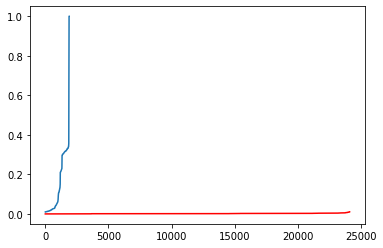

In [66]:
import matplotlib.pyplot as plt 

msr = np.sort(missing_value_ratio)
ratio = 0.01
l, r = msr[np.where(msr > ratio)], msr[np.where(msr <= ratio)]
plt.plot(l)
plt.plot(r, 'r')
plt.show()

In [67]:
# train_x, train_y 를 np.array 로 바꿈
train_x = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y = np.array(train_y)

# Validation set 나누기

In [68]:
from sklearn.model_selection import train_test_split

# train_data size : validation_data size = 4 : 1, random_state(seed) = 100
train_data, validation_data, train_labels, validation_labels = train_test_split(train_x, train_y, test_size=0.2, random_state=100)

In [69]:
print(train_data.shape)
print(train_labels.shape)
print(validation_data.shape)
print(validation_labels.shape)

(19286, 720, 8)
(19286, 288)
(4822, 720, 8)
(4822, 288)


## test data

In [70]:
test_data_list = [x for x in range(constant['total_day']-hyperparam['interval']+1, constant['total_day']+1)]
test_data = raw_data[raw_data["Day"].isin(test_data_list)]
test_data = test_data.drop(["TurbID", "Day", "Tmstamp"], axis = 1)

# 결측값이 너무 많은 데이터는 버림
test_missing_value = test_data.isnull().sum().sum()
total = test_data.notnull().sum().sum() + test_missing_value
ratio = test_missing_value/total
print("missing_value_ratio", ratio)

# 결측값 0 으로 채우기
test_data = test_data.fillna(0)

# 칼럼명 저장
colum_name = test_data.columns

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
print(test_data.shape)

missing_value_ratio 0.0007980928689883914
(134, 720, 8)


In [71]:
columns_info = "\n".join([f"{ind} : {val}" for ind, val in enumerate(colum_name)]) + '\n'
print(columns_info)

0 : Wspd
1 : Wdir
2 : Etmp
3 : Itmp
4 : Ndir
5 : Prtv
6 : Patv
7 : Pab



## 전처리 데이터 저장용 directory 생성

In [72]:
import os

directory = Path+f"interval-{hyperparam['interval']}, {hyperparam['normalize']}"
if not os.path.exists(directory):
    os.makedirs(directory)

## 하이퍼 파라미터 기록

In [73]:
with open(directory+"/data_info.txt", "w") as file:
    # data shape
    file.write("data shape\n")
    file.write(f"train_data : {train_data.shape}\n")
    file.write(f"train_data_labels : {train_labels.shape}\n")
    file.write(f"validation_data : {validation_data.shape}\n")
    file.write(f"validation_labels : {validation_labels.shape}\n")
    file.write(f"test_data : {test_data.shape}\n")
    file.write(f"test_data mission value ratio : {ratio}\n")
    file.write("\n")

    # colum info
    file.write("data colums info\n")
    file.write(f"columns info :\n{columns_info}\n")

    # hyperparam
    file.write("hyperparam\n")
    file.write(f"interval : {hyperparam['interval']}\n")
    file.write(f"missing_value_lowerbound : {hyperparam['missing_value_lowerbound']}\n")
    file.write(f"normalize : {hyperparam['normalize']}\n")
    file.write(f"day_to_predict : {constant['day_to_predict']}\n")
    file.write(f"total_day : {constant['total_day']}\n")
    file.write("\n")
    

# data 저장

In [74]:
np.save(directory+"/train_data", train_data)
np.save(directory+"/train_labels", train_labels)
np.save(directory+"/validation_data", validation_data)
np.save(directory+"/validation_labels", validation_labels)
np.save(directory+"/test_data", test_data)